In [7]:
import pickle
import numpy as np
import pandas as pd

import torch
import json
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from embedding import BertHuggingface
from geometrical_bias import SAME, WEAT, GeneralizedWEAT, DirectBias, MAC, normalize, cossim, EmbSetList, EmbSet, GeometricBias
from utils import CLFHead, SimpleCLFHead, CustomModel, JigsawDataset, BiosDataset, DebiasPipeline

In [9]:
ys = [np.asarray([0,1,0]), np.asarray([1,0,0]), np.asarray([1,1,0]), np.asarray([1,0,0])]
y_arr = np.asarray(ys)
y_arr

array([[0, 1, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 0, 0]])

In [10]:
np.sum(y_arr, axis=0)

array([3, 2, 0])

In [11]:
from datasets import load_dataset

dataset = load_dataset("jigsaw_unintended_bias", data_dir="../jigsaw_bias")

Found cached dataset jigsaw_unintended_bias (/home/saschroeder/.cache/huggingface/datasets/jigsaw_unintended_bias/default-data_dir=..%2Fjigsaw_bias/1.1.0/8f2a60d7ccd0f29648890f8c9141bf5dbd121b7d19616ba3cf39849e51d0c26b)
100%|█████████████████████████████████████████| 3/3 [00:00<00:00, 21.69it/s]


In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['target', 'comment_text', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date', 'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit', 'identity_annotator_count', 'toxicity_annotator_count'],
        num_rows: 1804874
    })
    test_private_leaderboard: Dataset({
        features: ['target', 'comment_text', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', '

In [10]:
dataset['train']

{'target': 0.6666666865348816,
 'comment_text': 'ur a sh*tty comment.',
 'severe_toxicity': 0.0476190485060215,
 'obscene': 0.6380952596664429,
 'identity_attack': 0.0,
 'insult': 0.3333333432674408,
 'threat': 0.0,
 'asian': nan,
 'atheist': nan,
 'bisexual': nan,
 'black': nan,
 'buddhist': nan,
 'christian': nan,
 'female': nan,
 'heterosexual': nan,
 'hindu': nan,
 'homosexual_gay_or_lesbian': nan,
 'intellectual_or_learning_disability': nan,
 'jewish': nan,
 'latino': nan,
 'male': nan,
 'muslim': nan,
 'other_disability': nan,
 'other_gender': nan,
 'other_race_or_ethnicity': nan,
 'other_religion': nan,
 'other_sexual_orientation': nan,
 'physical_disability': nan,
 'psychiatric_or_mental_illness': nan,
 'transgender': nan,
 'white': nan,
 'created_date': '2015-09-29 10:50:50.865549+00',
 'publication_id': 2,
 'parent_id': nan,
 'article_id': 2006,
 'rating': 0,
 'funny': 0,
 'wow': 0,
 'sad': 0,
 'likes': 0,
 'disagree': 0,
 'sexual_explicit': 0.009523809887468815,
 'identity_a

## TODO


In [4]:
from utils import CLFHead, SimpleCLFHead, CustomModel, JigsawDataset, BiosDataset, DebiasPipeline, upsample_defining_embeddings

In [5]:
jdata = JigsawDataset(n_folds=5, dataset_dir='../jigsaw_bias')

Found cached dataset jigsaw_unintended_bias (/home/saschroeder/.cache/huggingface/datasets/jigsaw_unintended_bias/default-data_dir=..%2Fjigsaw_bias/1.1.0/8f2a60d7ccd0f29648890f8c9141bf5dbd121b7d19616ba3cf39849e51d0c26b)
100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.00it/s]


In [6]:
jdata.sel_attributes('race-color')
jdata.set_data_split(0)

NameError: name 'n_folds' is not defined

In [261]:
j_configs = ['jigsaw_exp_religion.json', 'jigsaw_exp_race.json', 'jigsaw_exp_race2.json']
b_configs = ['bios_exp2.json', 'bios_exp4.json']

problem_models = {}
for config in b_configs+j_configs:
    with open('configs/'+config, 'r') as f:
        exp_config = json.load(f)
        
    save_file = exp_config['save_file'] #res_bios.pickle
    with open(save_file, 'rb') as handle:
        res = pickle.load(handle)
        exp_parameters = res['params']
        results = res['results']
        
    for i in range(len(exp_parameters)):
        if results[i]['recall'] < 0.3 or np.min(results[i]['class_recall']) < 0.1:
            if not exp_parameters[i]['embedder'] in problem_models.keys():
                problem_models[exp_parameters[i]['embedder']] = 1
            else:
                problem_models[exp_parameters[i]['embedder']] += 1

In [262]:
problem_models

{'bert-base-uncased': 11,
 'bert-large-uncased': 8,
 'distilbert-base-uncased': 11,
 'roberta-base': 14,
 'roberta-large': 17,
 'distilroberta-base': 10,
 'xlm-roberta-base': 19,
 'albert-base-v2': 9,
 'albert-large-v2': 14,
 'google/electra-large-generator': 9,
 'bert-base-multilingual-uncased': 12,
 'GroNLP/hateBERT': 13,
 'Twitter/twhin-bert-base': 10,
 'Twitter/twhin-bert-large': 13,
 'xlm-roberta-large': 19,
 'medicalai/ClinicalBERT': 14,
 'dbmdz/bert-base-historic-multilingual-cased': 18,
 'Davlan/afro-xlmr-large': 18,
 'albert-xlarge-v2': 16,
 'albert-xxlarge-v2': 21,
 'bert-large-uncased-whole-word-masking': 11,
 'Geotrend/bert-base-en-cased': 9,
 'Geotrend/bert-base-10lang-cased': 8,
 'Geotrend/bert-base-15lang-cased': 13,
 'Intel/bert-base-uncased-sparse-70-unstructured': 12,
 'Intel/bert-base-uncased-sparse-85-unstructured-pruneofa': 9,
 'Intel/distilbert-base-uncased-sparse-85-unstructured-pruneofa': 15,
 'Intel/distilbert-base-uncased-sparse-90-unstructured-pruneofa': 17,


## Evaluation
- check if debias reduces extrinsic biases
- plot correlation (job-wise vs. overall)
- cosine scores on train or eval data?

In [273]:
with open('data/protected_groups.json', 'r') as f:
    pg_config = json.load(f)
    
with open('configs/jigsaw_exp_gender.json', 'r') as f:
    exp_config = json.load(f)
    
with open(exp_config['batch_size_lookup'], 'r') as f:
    batch_size_lookup = json.load(f)
    
groups_by_bias_types = pg_config['groups_by_bias_types']
terms_by_groups = pg_config['terms_by_groups']

cosine_scores = {'SAME': SAME, 'WEAT': WEAT, 'gWEAT': GeneralizedWEAT, 'DirectBias': DirectBias, 'MAC': MAC}
optimizer = {'RMSprop': torch.optim.RMSprop, 'Adam': torch.optim.Adam}
criterions = {'BCEWithLogitsLosss': torch.nn.BCEWithLogitsLoss, 'MultiLabelSoftMarginLoss': torch.nn.MultiLabelSoftMarginLoss}

In [280]:
save_file = 'results/jigsaw_gender_old/res.pickle' #exp_config['save_file']
with open(save_file, 'rb') as handle:
    res = pickle.load(handle)
    exp_parameters = res['params']
    results = res['results']
    #results_test = res['results_eval']

In [278]:
results[0]

{'id': 8,
 'extrinsic': [0.003076896685338467,
  0.019611453323495204,
  0.011114856592205144,
  0.00657023700116789],
 'extrinsic_individual': [[0.0,
   0.0,
   0.0,
   -0.0276920701680462,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0341029046208329,
   0.0,
   0.0,
   -0.051127404722699166,
   0.0,
   0.0,
   0.0,
   0.0,
   0.09127277056792477],
  [0.0, 0.0, 0.0, -0.10003370932984629, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, -0.05913213301051101, 0.0, 0.0, 0.0, 0.0, 0.0]],
 'subgroup_AUC': [[0.0,
   0.0,
   0.0,
   8.584946912973882e-05,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [3.653306145675044e-05,
   0.0,
   0.0,
   1.556278544823961e-05,
   0.0,
   0.0,
   0.0,
   0.0,
   0.000104958208876043],
  [0.0, 0.0, 0.0, 0.00037289017679418006, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.00018799124214371817, 0.0, 0.0, 0.0, 0.0, 0.0]],
 'BPSN': [[0.0, 0.0, 0.0, 0.0005341430012583998, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.00012115831441105385,
   0.0,
   0.0,
   0.0004673696045444581,

In [265]:
assert len(exp_parameters) == len(results), "shape mismatch: "+str(len(exp_parameters))+" vs. "+str(len(results))

AssertionError: shape mismatch: 168 vs. 124

In [266]:
exp_parameters[124]

{'bias_scores': ['SAME', 'WEAT', 'gWEAT', 'DirectBias', 'MAC'],
 'n_fold': 4,
 'batch_size': 8,
 'epochs': 5,
 'group_weights': False,
 'bias_type': 'gender',
 'embedder': 'cardiffnlp/twitter-roberta-base-irony',
 'head': 'SimpleCLFHead',
 'optimizer': 'RMSprop',
 'criterion': 'BCEWithLogitsLoss',
 'lr': 0.001,
 'debias': False}

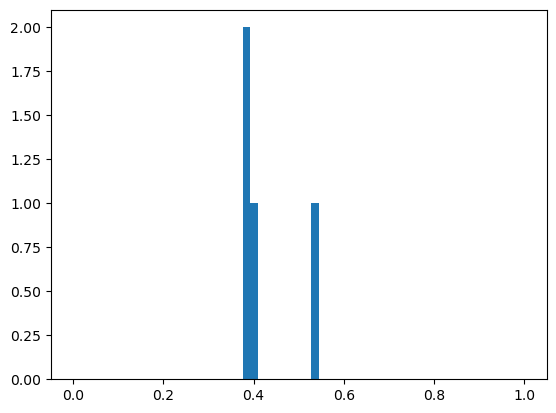

In [281]:
recalls = [res['recall'] for res in results]
counts, bins = np.histogram(recalls)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlim(-0.05, 1.05)
plt.show()

In [238]:
score_list = list(cosine_scores.keys())+['extrinsic']
scores_per_bias_type = {bt : {score: [] for score in score_list+['subgroup_AUC', 'BNSP', 'BPSN']} for bt in exp_config['bias_types']}
class_wise_scores = {score: [] for score in score_list}

corr_per_score = {score: {'r': [], 'p': []} for score in score_list}
for i in range(len(results)):
    print("experiment", i, "with bias type", exp_parameters[i]['bias_type'], "and", exp_parameters[i]['embedder'])
    
    if results[i]['recall'] < 0.3:
        print("skip because recall < 0.3")
        continue
    
    for score in score_list:
        scores_per_bias_type[exp_parameters[i]['bias_type']][score].append(results[i][score])
    for score in ['subgroup_AUC', 'BNSP', 'BPSN']:
        scores_per_bias_type[exp_parameters[i]['bias_type']][score].append(np.mean(results[i][score], axis=1))
    
    for score in score_list:
        if score == 'gWEAT':
            continue
        if score == 'WEAT' and len(groups_by_bias_types[exp_parameters[i]['bias_type']]) > 2:
            continue
        for score2 in score_list:
            if score == score2 or score2 == 'gWEAT':
                continue
            if score2 == 'WEAT' and len(groups_by_bias_types[exp_parameters[i]['bias_type']]) > 2:
                continue
                
            # class-wise bias scores
            scores1 = np.abs(np.mean(results[i][score+'_individual'], axis=0))
            scores2 = np.abs(np.mean(results[i][score2+'_individual'], axis=0))
            class_wise_scores[score].append(scores1)
            try:
                slope, intercept, r, p, std_err = scipy.stats.linregress(scores1, scores2)
            except ValueError:
                print("invalid values for ", score, score2)
                print(results[i]['recall'])
            if 'extrinsic' in score and p < 0.1:
                print(score, score2, "R="+str(r)+" (p="+str(p)+")")
            if score == 'extrinsic':
                corr_per_score[score2]['r'].append(r)
                corr_per_score[score2]['p'].append(p)
    print()
    print()

experiment 0 with bias type religion and bert-base-uncased


experiment 1 with bias type religion and bert-base-uncased


experiment 2 with bias type religion and bert-base-uncased


experiment 3 with bias type religion and bert-base-uncased
skip because recall < 0.3
experiment 4 with bias type religion and bert-large-uncased


experiment 5 with bias type religion and bert-large-uncased


experiment 6 with bias type religion and bert-large-uncased


experiment 7 with bias type religion and bert-large-uncased
skip because recall < 0.3
experiment 8 with bias type religion and distilbert-base-uncased


experiment 9 with bias type religion and distilbert-base-uncased


experiment 10 with bias type religion and distilbert-base-uncased
skip because recall < 0.3
experiment 11 with bias type religion and distilbert-base-uncased


experiment 12 with bias type religion and roberta-base


experiment 13 with bias type religion and roberta-base
skip because recall < 0.3
experiment 14 with bias type

In [245]:
for score, vals in corr_per_score.items():
    print(score)
    print("R =", np.mean(np.abs(vals['r'])), " (p =", np.mean(vals['p']), ")")

SAME
R = 0.3534722652259579  (p = 0.5131568410418224 )
WEAT
R = nan  (p = nan )
gWEAT
R = nan  (p = nan )
DirectBias
R = 0.3533782185934686  (p = 0.5105754773638891 )
MAC
R = 0.3219552111846254  (p = 0.5505103291808086 )
extrinsic
R = nan  (p = nan )


/home/saschroeder/anaconda3/envs/plmbias/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/saschroeder/anaconda3/envs/plmbias/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


race-color
SAME


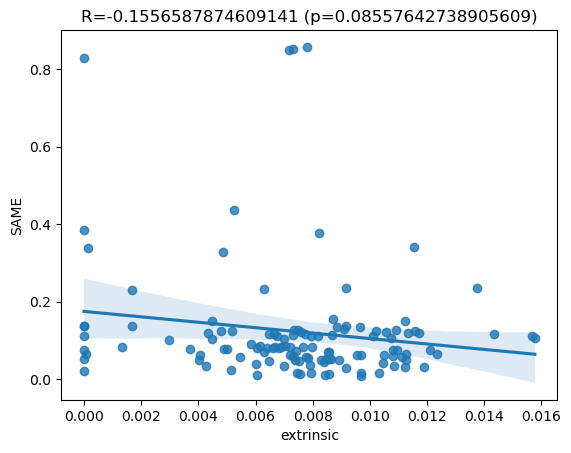


WEAT


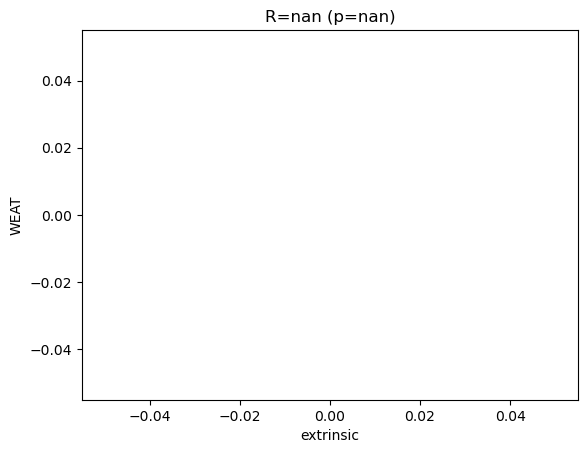


gWEAT


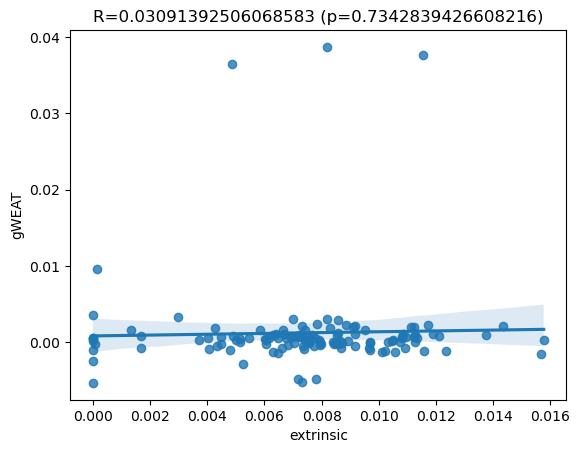


DirectBias


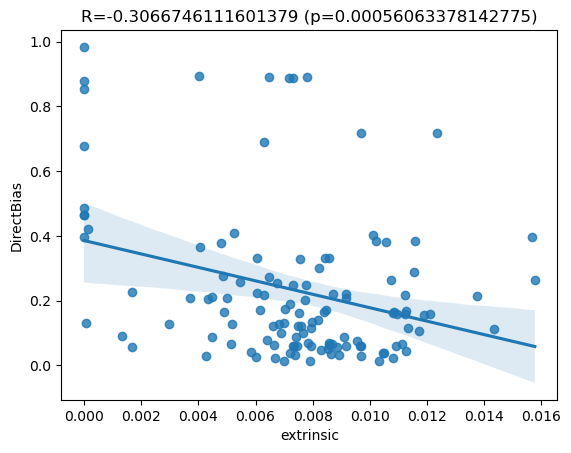


MAC


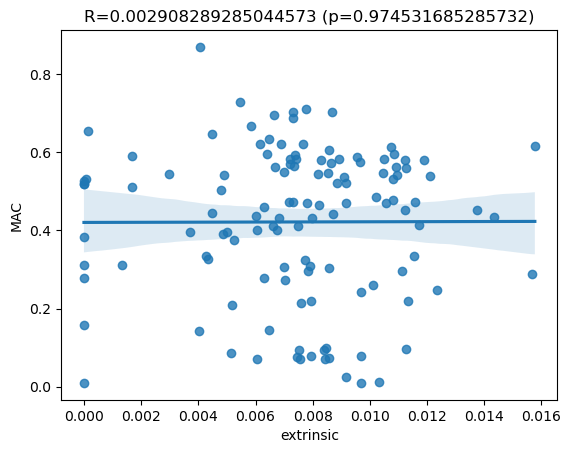


race-color
SAME


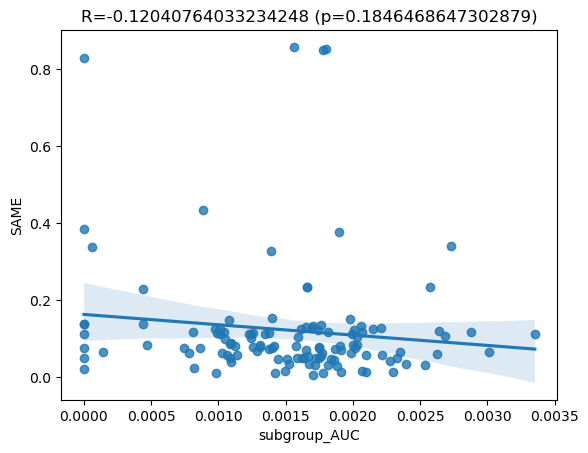


WEAT


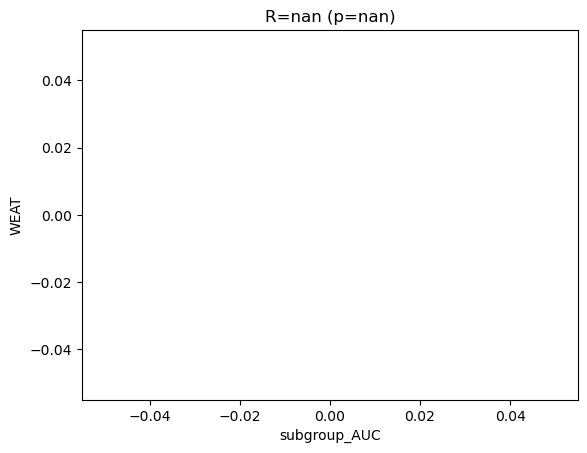


gWEAT


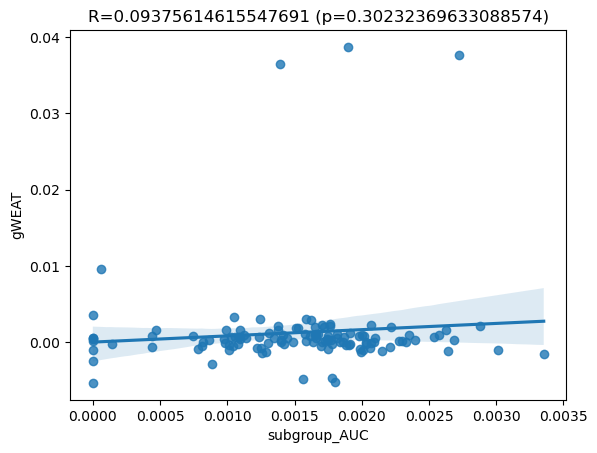


DirectBias


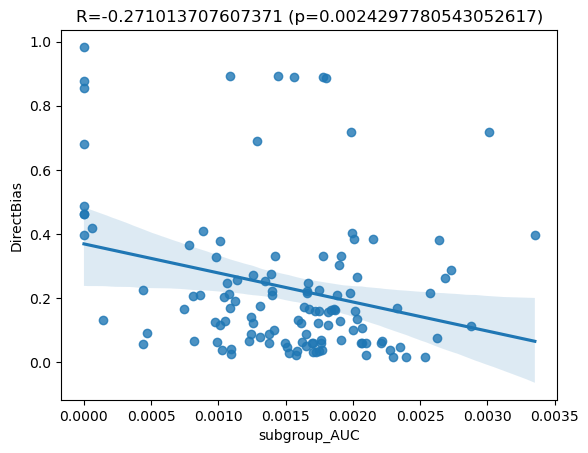


MAC


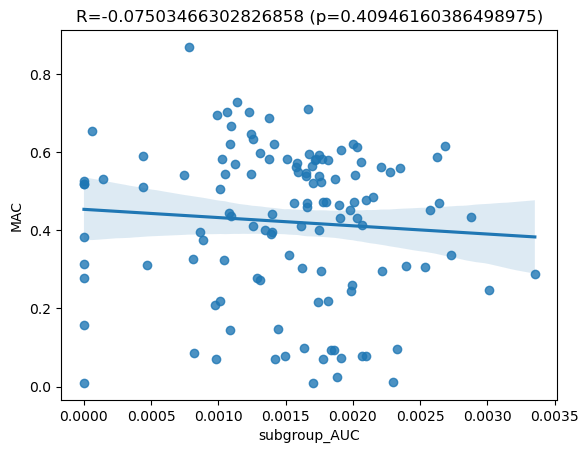


race-color
SAME


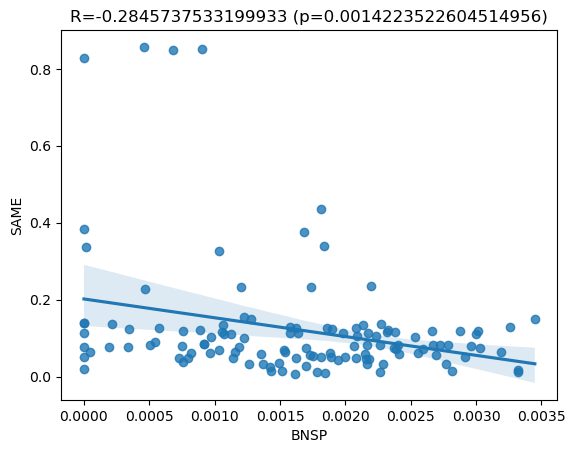


WEAT


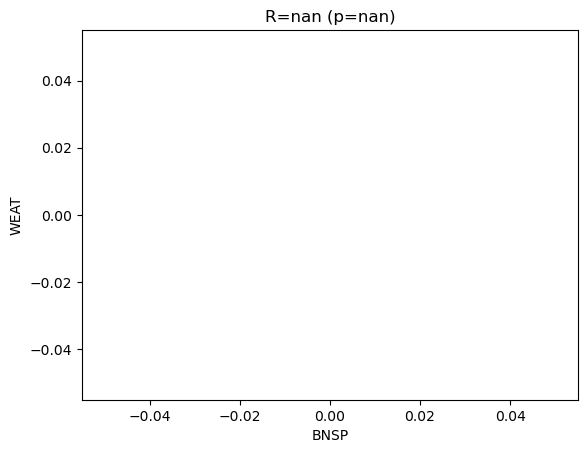


gWEAT


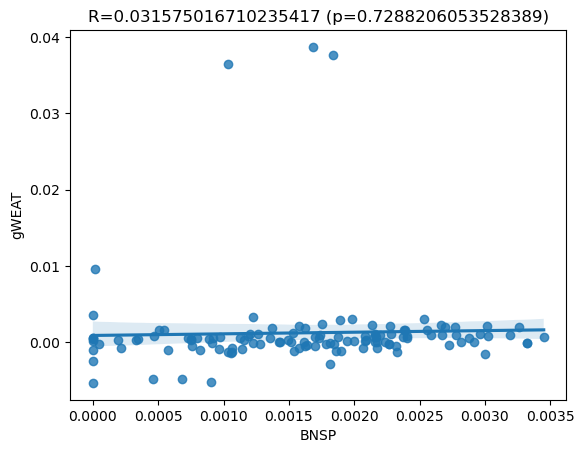


DirectBias


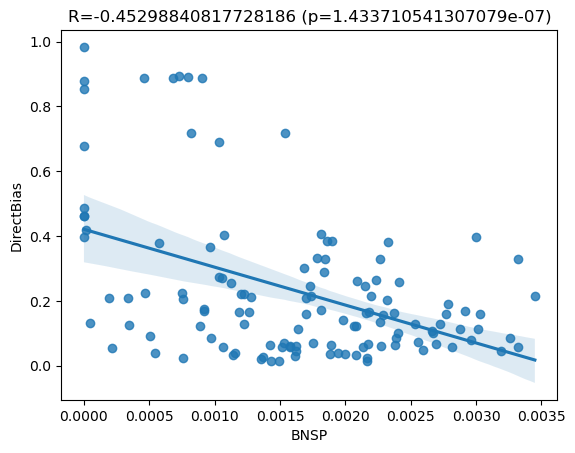


MAC


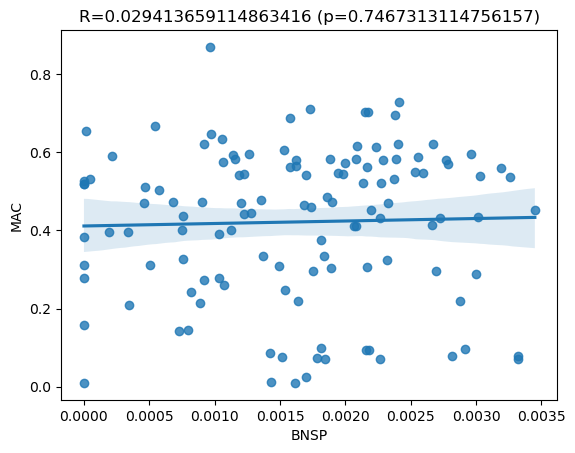


race-color
SAME


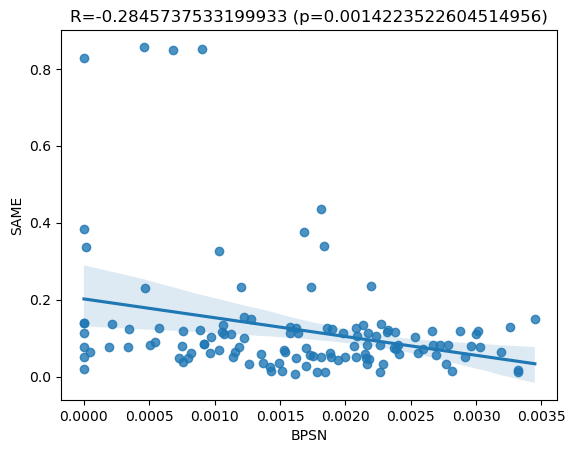


WEAT


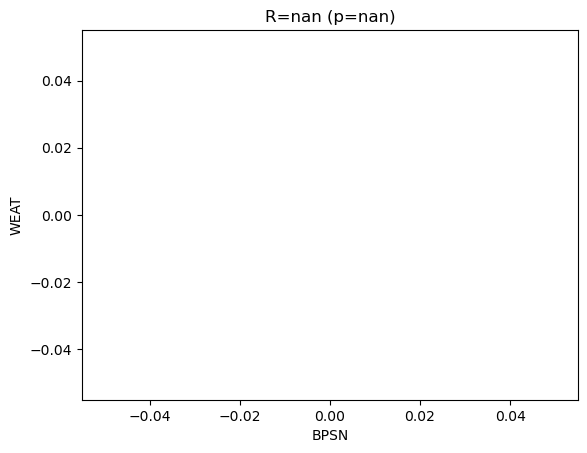


gWEAT


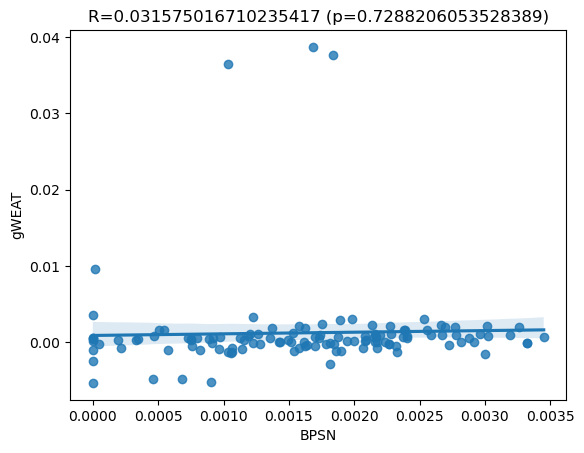


DirectBias


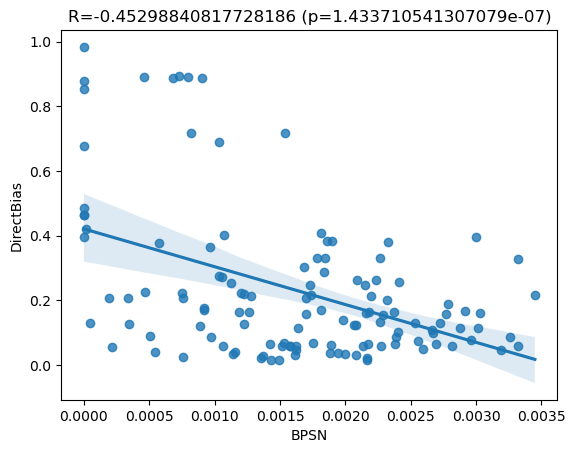


MAC


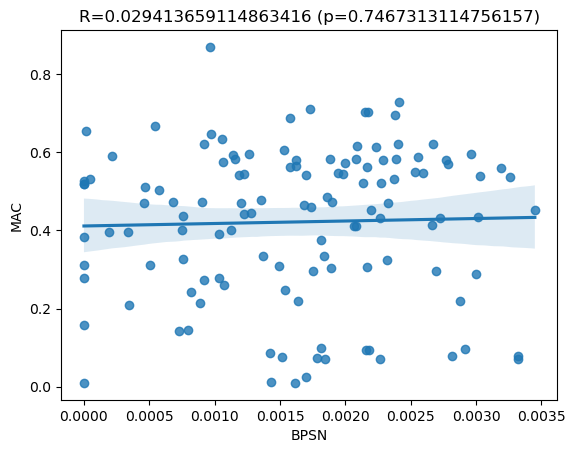

In [225]:
mean_scores = {}
for bt, res in scores_per_bias_type.items():
    mean_scores[bt] = {score: np.mean(scores_per_bias_type[bt][score], axis=1) for score in score_list+['subgroup_AUC', 'BNSP', 'BPSN']}

for comp in ['extrinsic', 'subgroup_AUC', 'BNSP', 'BPSN']:
    for bt, res in mean_scores.items():
        df = pd.DataFrame(res)
        print(bt)
        for score in score_list:
            if not score == 'extrinsic':
                print(score)
                slope, intercept, r, p, std_err = scipy.stats.linregress(df.loc[:,comp], df.loc[:,score])
                #print(r, p)
                sns.regplot(x=comp, y=score, data=df).set_title("R="+str(r)+" (p="+str(p)+")")
                plt.show()
                print()

0
SAME 369
DirectBias 369
MAC 369
extrinsic 369
SAME


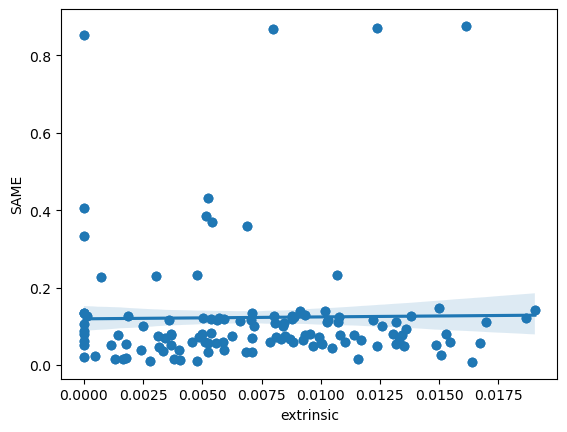

DirectBias


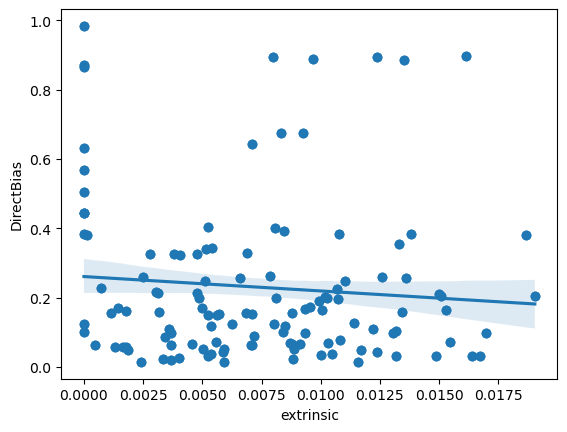

MAC


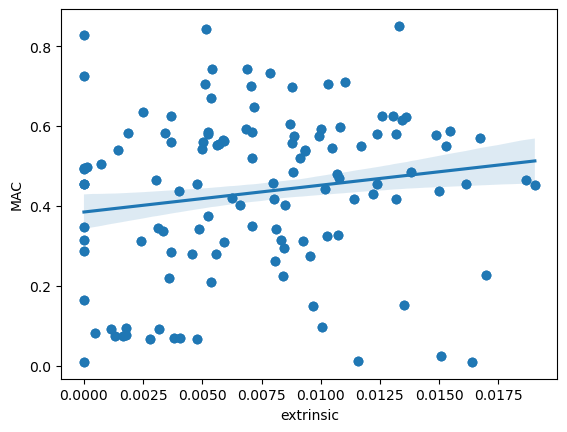



1
SAME 369
DirectBias 369
MAC 369
extrinsic 369
SAME


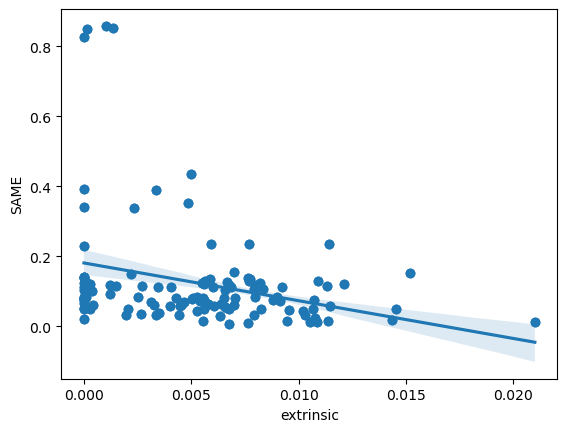

DirectBias


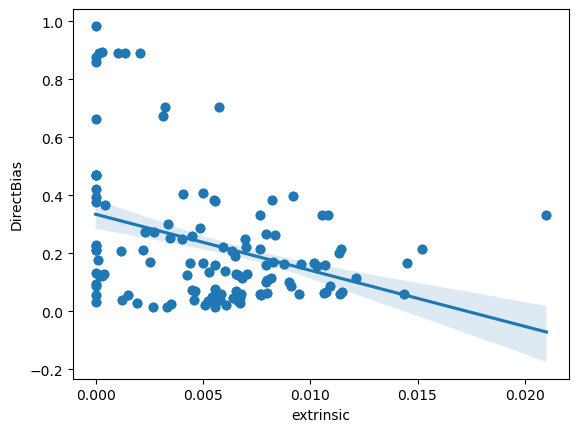

MAC


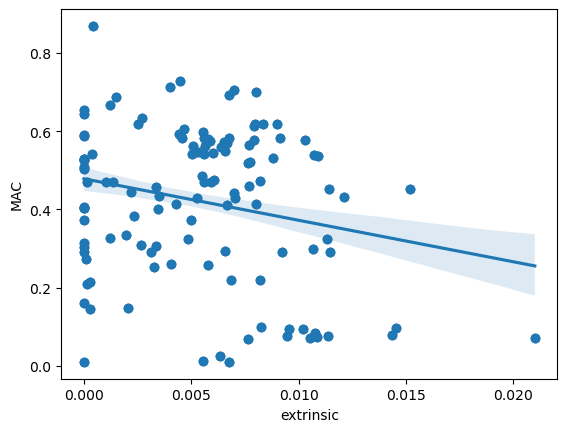



2
SAME 369
DirectBias 369
MAC 369
extrinsic 369
SAME


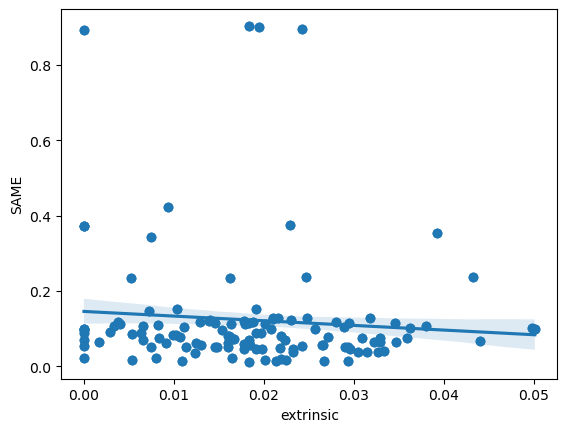

DirectBias


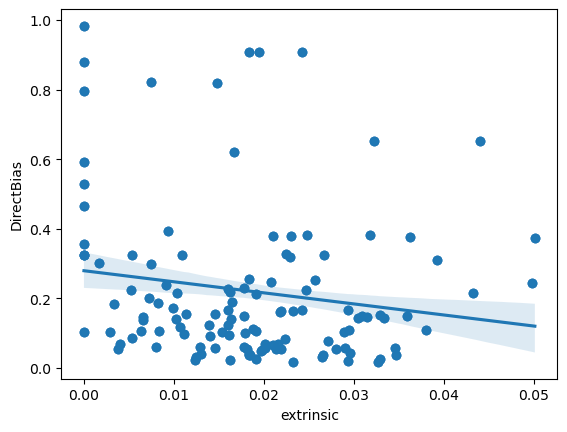

MAC


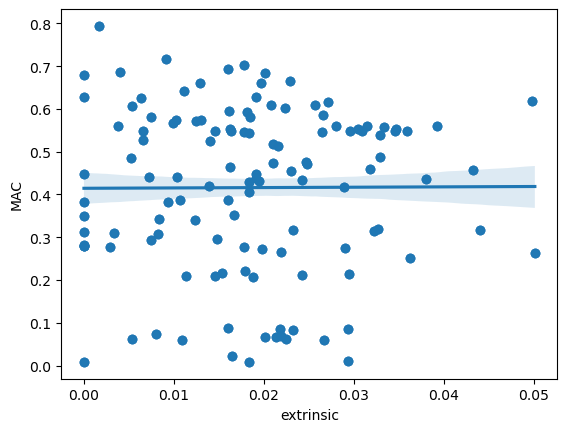



3
SAME 369
DirectBias 369
MAC 369
extrinsic 369
SAME


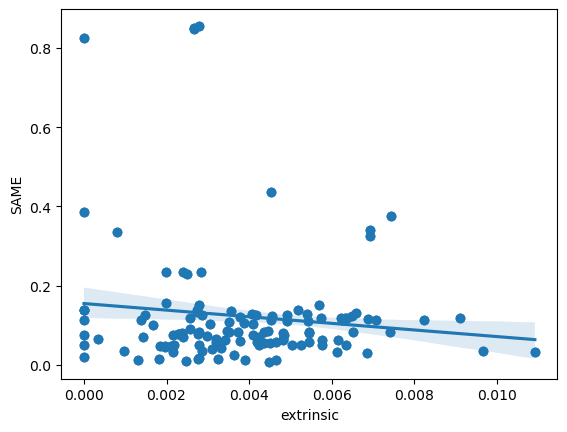

DirectBias


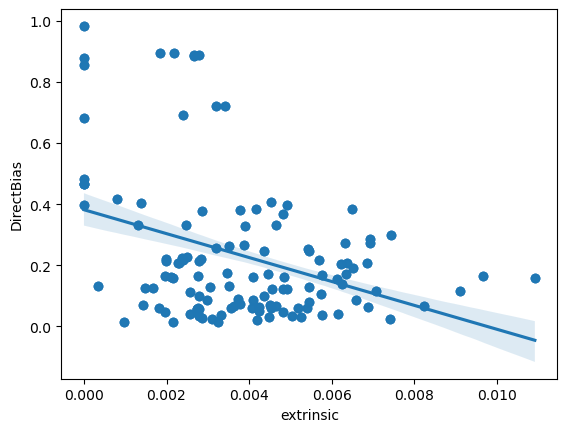

MAC


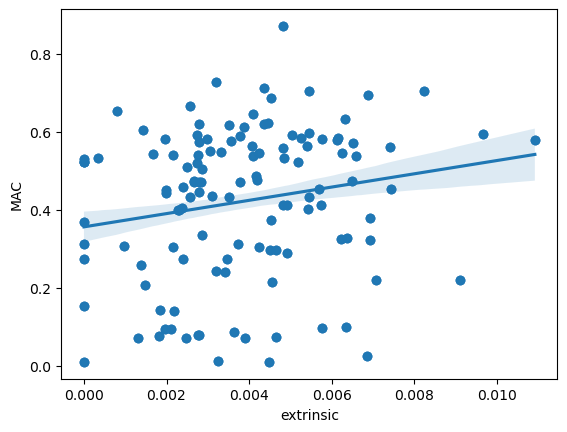



4
SAME 369
DirectBias 369
MAC 369
extrinsic 369
SAME


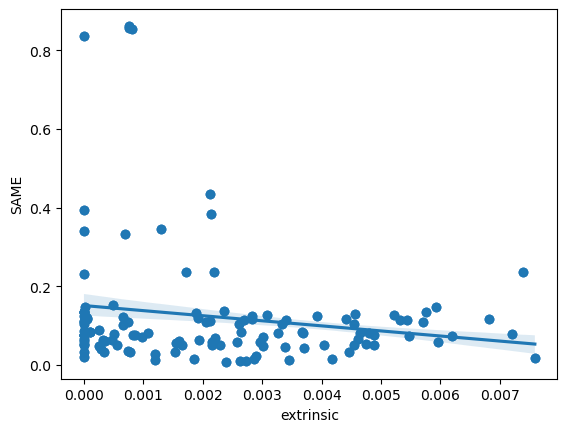

DirectBias


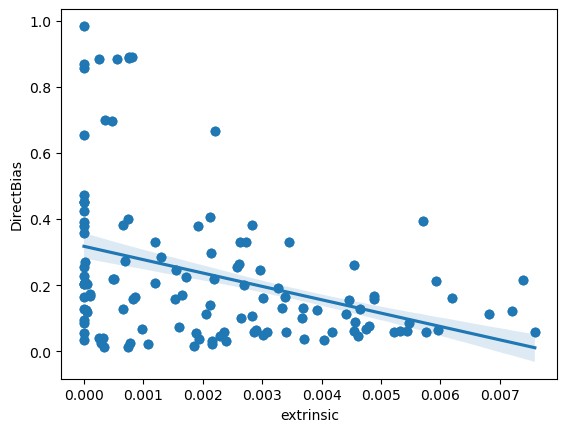

MAC


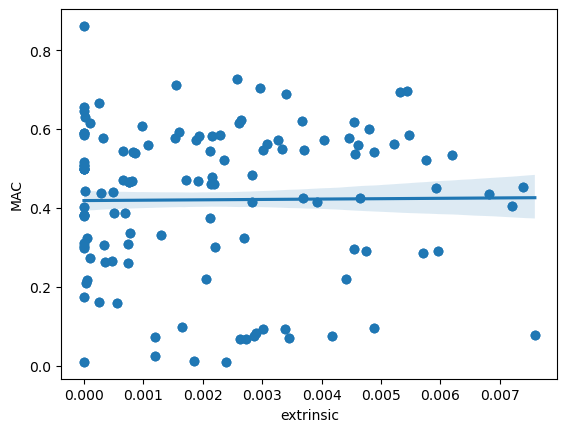

In [226]:
n_classes = class_wise_scores['SAME'][0].shape[0]
stacked_scores = {c: {} for c in range(n_classes)}
for score in score_list:
    if not (score == 'gWEAT' or score == 'WEAT'):
        for c in range(n_classes):
            stacked_scores[c][score] = np.asarray(class_wise_scores[score])[:,c]

for c in range(n_classes):
    print(c)
    for score in stacked_scores[c].keys():
        print(score, len(stacked_scores[c][score]))
    df = pd.DataFrame(stacked_scores[c])
    for score in stacked_scores[0].keys():
        if not score == 'extrinsic':
            print(score)
            sns.regplot(x="extrinsic", y=score, data=df, label="class "+str(c))        
            plt.show()
    print()
    print()

In [239]:
debias_ks = exp_config['debias_k']
embedder = exp_config['embedders']

In [240]:
results[0]['SAME']

[0.20541092917006032,
 0.20510377266947832,
 0.20521064173697043,
 0.20472219461304522]

In [241]:
results[3]['SAME']

[0.20755175964119624,
 0.2071444931614397,
 0.20646650439407788,
 0.20595735967700837]

In [242]:
len(exp_parameters)

168

In [243]:
all_scores = list(cosine_scores.keys())+['extrinsic']
exp_idx = 0
bias_decreased = {score: {k: [] for k in debias_ks} for score in all_scores}
for model in embedder:
    if exp_idx+len(debias_ks) >= len(results):
        continue
    low_recall = False
    for idx in range(exp_idx, exp_idx+len(debias_ks)):
        if results[idx]['recall'] < 0.3:
            low_recall = True
    if low_recall:
        print("skip ", model, "because of low recall")
        exp_idx += len(debias_ks)+1
        continue
        
    default_idx = exp_idx
    debias_ids = [exp_idx+i+1 for i,k in enumerate(debias_ks)]
    exp_idx += len(debias_ks)+1
    for score in all_scores:
        if score not in results[default_idx].keys():
            continue
        default_scores = results[default_idx][score] # one per split

        for i,k in enumerate(debias_ks):
            for i, fold in enumerate(results[debias_ids[i]][score]):
                bias_decreased[score][k].append(fold < default_scores[i])

print("percentage of experiments with decreased extrinsic biases after hard debiasing (per k):")
for score in all_scores:
    print(score)
    for k in debias_ks:
        print(k, np.sum(bias_decreased[score][k])/len(bias_decreased[score][k]))
    print()
        

skip  distilbert-base-uncased because of low recall
skip  roberta-base because of low recall
skip  roberta-large because of low recall
skip  distilroberta-base because of low recall
skip  xlm-roberta-base because of low recall
skip  albert-large-v2 because of low recall
skip  google/electra-base-generator because of low recall
skip  google/electra-large-generator because of low recall
skip  Twitter/twhin-bert-base because of low recall
skip  Twitter/twhin-bert-large because of low recall
skip  xlm-roberta-large because of low recall
skip  medicalai/ClinicalBERT because of low recall
skip  dbmdz/bert-base-historic-multilingual-cased because of low recall
skip  Davlan/afro-xlmr-large because of low recall
skip  Geotrend/bert-base-en-cased because of low recall
skip  Geotrend/bert-base-15lang-cased because of low recall
skip  Intel/distilbert-base-uncased-sparse-85-unstructured-pruneofa because of low recall
skip  Intel/distilbert-base-uncased-sparse-90-unstructured-pruneofa because of lo

SAME
1


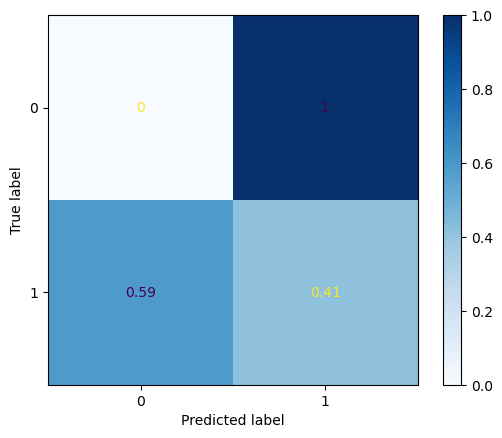

ROC AUC:  0.20535714285714285

3


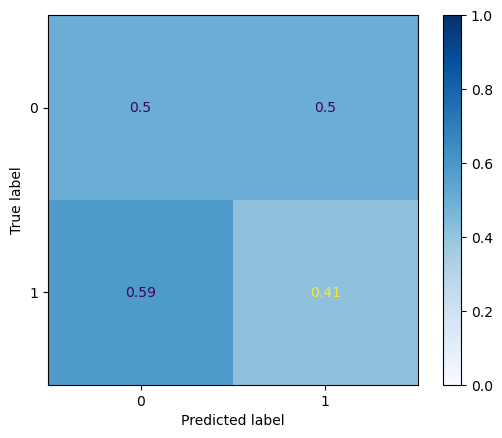

ROC AUC:  0.4568965517241379

5


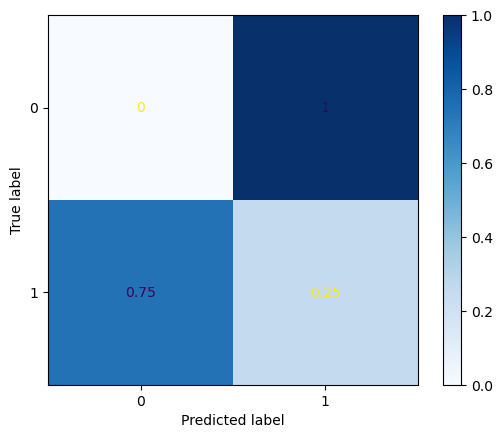

ROC AUC:  0.1271186440677966


WEAT
1


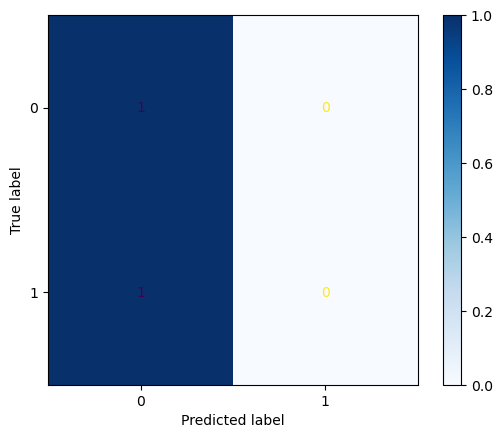

ROC AUC:  0.5

3


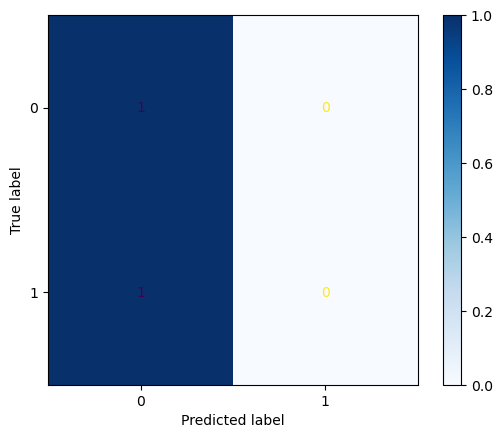

ROC AUC:  0.5

5


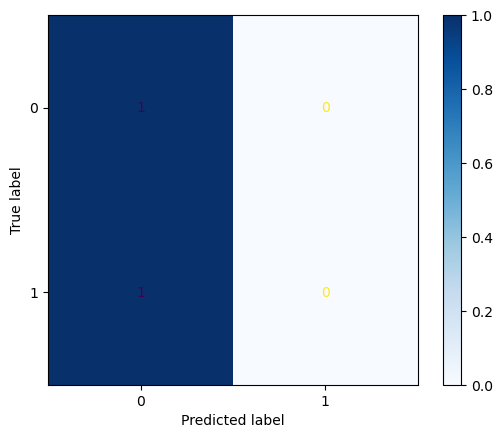

ROC AUC:  0.5


gWEAT
1


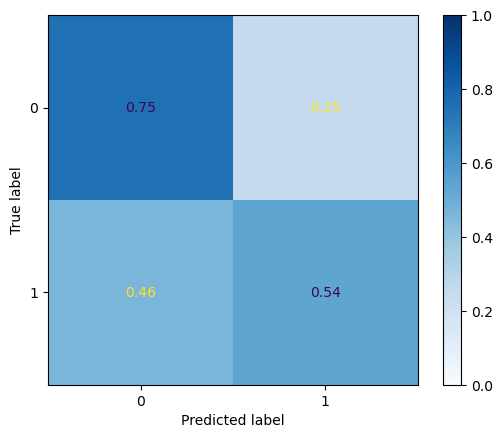

ROC AUC:  0.6428571428571428

3


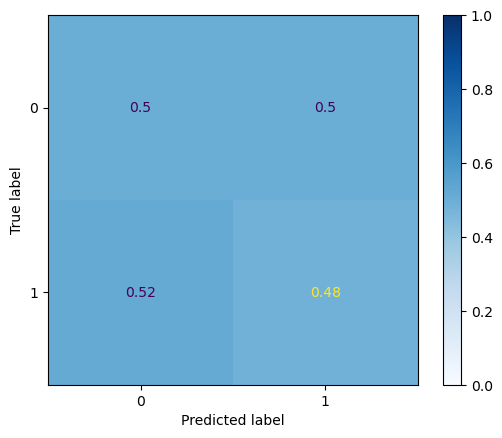

ROC AUC:  0.4913793103448276

5


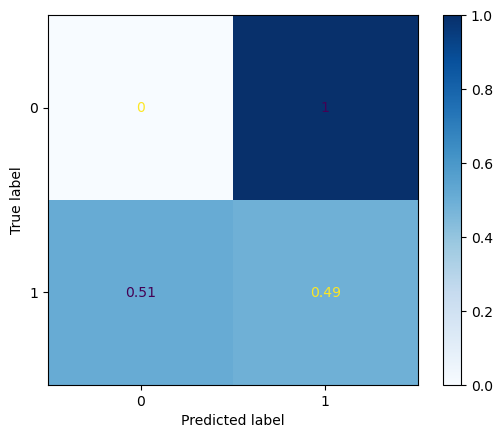

ROC AUC:  0.2457627118644068


DirectBias
1


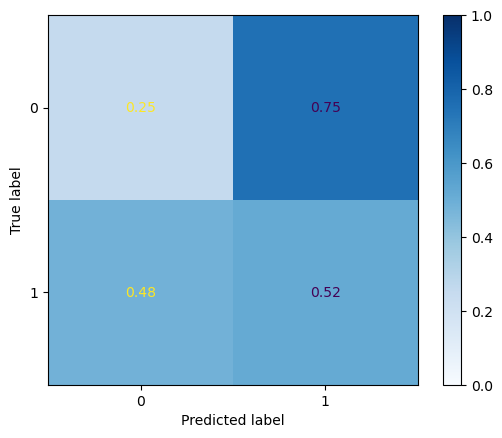

ROC AUC:  0.38392857142857145

3


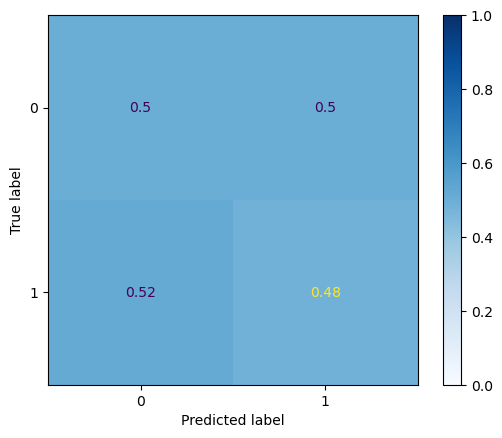

ROC AUC:  0.4913793103448276

5


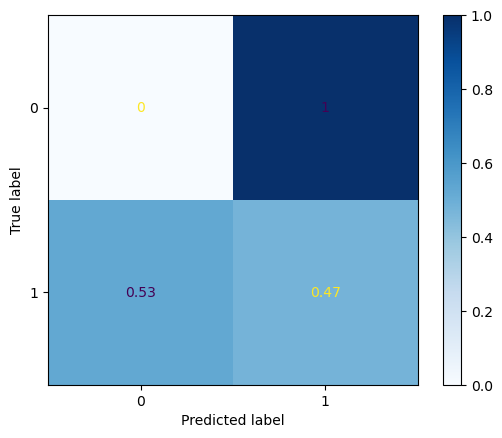

ROC AUC:  0.23728813559322035


MAC
1


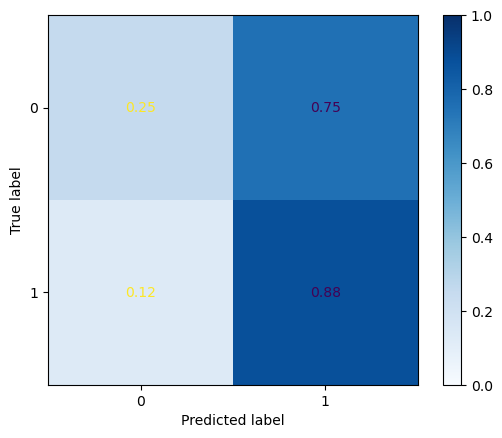

ROC AUC:  0.5625

3


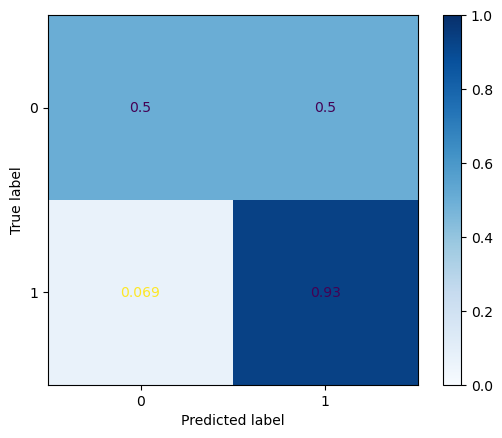

ROC AUC:  0.7155172413793103

5


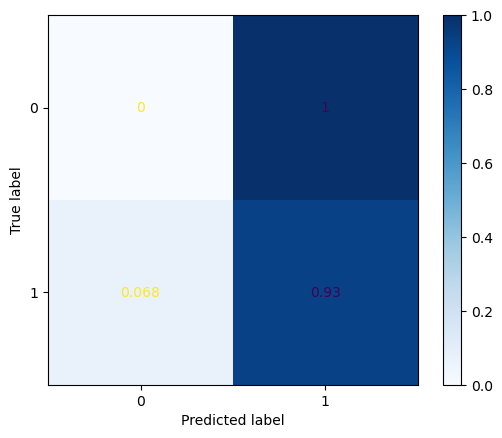

ROC AUC:  0.4661016949152542




In [244]:
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay

for score in cosine_scores.keys():
    print(score)
    for k in debias_ks:
        print(k)
        cm = confusion_matrix(bias_decreased['extrinsic'][k],bias_decreased[score][k], normalize='true')
        cm_display = ConfusionMatrixDisplay(cm).plot()
        cm_display.ax_.get_images()[0].set_clim(0, 1)
        cm_display.ax_.get_images()[0].set_cmap(plt.cm.Blues)
        plt.show()
        print("ROC AUC: ", roc_auc_score(bias_decreased['extrinsic'][k],bias_decreased[score][k]))
        #fpr, tpr, _ = roc_curve(bias_decreased['extrinsic'][k],bias_decreased[score][k])
        #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        print()
    print()

In [233]:
decrease_agree = {score: {k: [] for k in debias_ks} for score in cosine_scores}
for score in cosine_scores:
    exp_idx = 0
    for model in embedder:
        if exp_idx >= len(results):
            print("ran out of results")
            break
        if results[exp_idx]['recall'] < 0.3:
            print("skip ", model, "because of low recall")
            exp_idx += len(debias_ks)+1
            continue
        default_scores_ex = results[exp_idx]['extrinsic'] # one per split
        default_scores_cos = results[exp_idx][score] # one per split
        exp_idx += 1

        for k in debias_ks:
            for i, fold in enumerate(results[exp_idx]['extrinsic']):
                extrinsic_decrease = fold < default_scores_ex[i]
                cosine_decrease = results[exp_idx][score][i] < default_scores_cos[i]
                decrease_agree[score][k].append(extrinsic_decrease == cosine_decrease)
            exp_idx += 1

print("how often scores agree with the extrinsic biases regarding the reduction of biases after debiasing:")
for score in cosine_scores:
    for k in debias_ks:
        print(score, k, np.sum(decrease_agree[score][k])/len(decrease_agree[score][k]))

skip  bert-large-uncased because of low recall
skip  medicalai/ClinicalBERT because of low recall
skip  dbmdz/bert-base-historic-multilingual-cased because of low recall
skip  Davlan/afro-xlmr-large because of low recall
skip  albert-xlarge-v2 because of low recall
skip  albert-xxlarge-v2 because of low recall
skip  Geotrend/bert-base-en-cased because of low recall
skip  Geotrend/bert-base-10lang-cased because of low recall
skip  Intel/distilbert-base-uncased-sparse-90-unstructured-pruneofa because of low recall
skip  gpt2-large because of low recall
skip  bert-large-uncased because of low recall
skip  medicalai/ClinicalBERT because of low recall
skip  dbmdz/bert-base-historic-multilingual-cased because of low recall
skip  Davlan/afro-xlmr-large because of low recall
skip  albert-xlarge-v2 because of low recall
skip  albert-xxlarge-v2 because of low recall
skip  Geotrend/bert-base-en-cased because of low recall
skip  Geotrend/bert-base-10lang-cased because of low recall
skip  Intel/dis

In [169]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW

model_name = 'bert-base-uncased'
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True,
                                                                        num_labels=num_labels,
                                                                        output_hidden_states=True,
                                                                        output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)#, max_length=512, truncation=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [170]:
tokenizer.max_length

AttributeError: 'BertTokenizerFast' object has no attribute 'max_length'

In [ ]:
model.max_model_input_sizes

In [ ]:
from transformers import PreTrainedTokenizerBase

PreTrainedTokenizerBase.max_model_input_sizes

In [ ]:
model.config

In [171]:
model.config.max_position_embeddings

512